In [0]:
%pip install tzwhere
%pip install geopandas
%pip install pyspark_dist_explore

Python interpreter will be restarted.
  Created wheel for tzwhere: filename=tzwhere-3.0.3-py3-none-any.whl size=23742600 sha256=8a2c216fc8320c037263de1b989dd33b440a4a0ba42d728d0c546224ff4bc4a2
  Stored in directory: /home/spark-ff84b610-5067-4c76-9385-bf/.cache/pip/wheels/1c/5b/38/2c0772ba05aa51fefb242a15ed85fb649990712901b6c80458
Successfully built tzwhere
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql.functions import *
from pyspark.sql import *
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.regression import (
    LinearRegression,
    RandomForestRegressor,
    DecisionTreeRegressor,
    GBTRegressor,
)
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
)
from pyspark.ml.feature import (
    VectorAssembler,
    StandardScaler,
    MinMaxScaler,
    StringIndexer,
    OneHotEncoder,
)
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import (
    RegressionEvaluator,
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator,
)
from pyspark.ml import Pipeline
import numpy as np
import plotly
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import itertools
import re
import pytz

# from tzwhere import tzwhere
# import geopandas as gpd
# import pyspark_dist_explore as psgraph
BACKGROUND = "black"
FOREGROUND = "#73F9CB"

# Estimated Time of Delay ✈ 
## ML Based Flight Departure Delay Prediction 
### W261 Final Project Phase 2
### Section 7 - Group1 - Team 24

#### Regression Analaysis without Engineered Features

In [0]:
display(dbutils.fs.ls(f"/mnt/mids-w261-joined/"))

path name size modificationTime dbfs:/mnt/mids-w261-joined/YEAR=2015/ YEAR=2015/ 0 1658437611000 dbfs:/mnt/mids-w261-joined/YEAR=2016/ YEAR=2016/ 0 1658437611000 dbfs:/mnt/mids-w261-joined/YEAR=2017/ YEAR=2017/ 0 1658437611000 dbfs:/mnt/mids-w261-joined/YEAR=2018/ YEAR=2018/ 0 1658437611000 dbfs:/mnt/mids-w261-joined/YEAR=2019/ YEAR=2019/ 0 1658437611000 dbfs:/mnt/mids-w261-joined/YEAR=2020/ YEAR=2020/ 0 1658437611000 dbfs:/mnt/mids-w261-joined/YEAR=2021/ YEAR=2021/ 0 1658437611000 dbfs:/mnt/mids-w261-joined/_SUCCESS _SUCCESS 0 1658437611000 dbfs:/mnt/mids-w261-joined/_committed_1995221853517722120 _committed_1995221853517722120 38 1658437611000

### Load the Raw Data

Initially the joined data provided by the instructors has the following sizes:
  * joined data: 42271633 rows, 168 columns

In [0]:
data_BASE_DIR = "dbfs:/mnt/mids-w261-joined/"

df_2015 = spark.read.parquet(f"{data_BASE_DIR}YEAR=2015/")
df_2016 = spark.read.parquet(f"{data_BASE_DIR}YEAR=2016/")
df_2017 = spark.read.parquet(f"{data_BASE_DIR}YEAR=2017/")
df_2018 = spark.read.parquet(f"{data_BASE_DIR}YEAR=2018/")
df_2019 = spark.read.parquet(f"{data_BASE_DIR}YEAR=2019/")
df_2020 = spark.read.parquet(f"{data_BASE_DIR}YEAR=2020/")
df_2021 = spark.read.parquet(f"{data_BASE_DIR}YEAR=2021/")

data = df_2015.union(df_2016)
data = data.union(df_2017)
data = data.union(df_2018)
data = data.union(df_2019)
data = data.union(df_2020)
data = data.union(df_2021)

In [0]:
data_count = data.count()
number_of_columns = len(data.columns)
print(
    f"The total number of rows is {data_count} and total number of columns is {number_of_columns}"
)

The total number of rows is 42271633 and total number of columns is 168


In [0]:
# Let's ensure there are no duplicates
data = data.dropDuplicates()
# dbutils.data.summarize(data)

We have a couple of columns with missing values. let's drop the columns that have more than 40% null values.

In [0]:
# Let's go ahead to drop columns with missing data that are above 40%.

data = data.drop(
    "CARRIER_DELAY",
    "WEATHER_DELAY",
    "NAS_DELAY",
    "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "FIRST_DEP_TIME",
    "TOTAL_ADD_GTIME",
    "LONGEST_ADD_GTIME",
    "origin_weather_Avg_HourlyPressureChange",
    "origin_weather_Avg_HourlyWindGustSpeed",
    "dest_weather_Avg_HourlyPressureChange",
    "dest_weather_Avg_HourlyWindGustSpeed",
    "CANCELLATION_CODE",
)

# We also have a couple of columns with about 3% of missing data. Since this is small number of NA we can just drop the NA.
data = data.na.drop()



### Blob Storage 
<div>
  <table>
    <tr> <td><img src="https://media3.giphy.com/media/y2WVrfoLeD8yMaNxr5/200w.gif?cid=6c09b952y454jw98c0kz8dej0pzbgme3klo72toxv1ycwut7&rid=200w.gif&ct=g" width=150%></td> <td>The following cell will allow users to read and write from and Azure Binary Large Object (BLOB) cloud storage container that was configured to be accessible to all team members. The 'blob_url' path generated from this code is used subsequently for caching the results of slow operations like the joining of the full weather and flights data set and saving the cross validation time series splits.</td>   
      
  </table>
</div>

In [0]:
blob_container = (
    "###"  # The name of your container created in https://portal.azure.com
)
storage_account = "###"  # The name of your Storage account created in https://portal.azure.com
secret_scope = "###"  # The name of the scope created in your local computer using the Databricks CLI
secret_key = "###"  # saskey The name of the secret key created in your local computer using the Databricks CLI
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
    f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
    dbutils.secrets.get(scope=secret_scope, key=secret_key),
)

In [0]:
data.printSchema()

root
 |-- _utc_dept_ts: timestamp (nullable = true)
 |-- _utc_dept_minus2_ts: timestamp (nullable = true)
 |-- _utc_dept_actual_ts: timestamp (nullable = true)
 |-- _utc_arr_ts: timestamp (nullable = true)
 |-- _utc_arr_actual_ts: timestamp (nullable = true)
 |-- _dep_time_str: string (nullable = true)
 |-- _local_dept_ts: timestamp (nullable = true)
 |-- _local_dept_minus2_ts: timestamp (nullable = true)
 |-- _local_dept_actual_ts: timestamp (nullable = true)
 |-- _local_at_src_airport_arr_ts: timestamp (nullable = true)
 |-- _local_at_src_airport_arr_actual_ts: timestamp (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- OP_CAR

In [0]:
# Let's check numner of rows and columns after removing duplicates and null values
data_count = data.count()
number_of_columns = len(data.columns)
print(
    f"The total number of rows is {data_count} and total number of columns is {number_of_columns}"
)

The total number of rows is 36976385 and total number of columns is 155


In [0]:
display(data)

_utc_dept_ts _utc_dept_minus2_ts _utc_dept_actual_ts _utc_arr_ts _utc_arr_actual_ts _dep_time_str _local_dept_ts _local_dept_minus2_ts _local_dept_actual_ts _local_at_src_airport_arr_ts _local_at_src_airport_arr_actual_ts QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP origin_airport_iata origin_airport_tz origin_airport_type origin_airport_elevation origin_airport_iso_country origin_airport_iso_region origin_airport_ws_station_id dest_airport_iata dest_airport_tz dest_airport_type dest_airport_elevation dest_airport_iso_country dest_airport_iso_region dest_airport_ws_station_id origin_weather_Station origin_weather_Datehour origin_weather_Avg_Elevation origin_weather_Avg_HourlyAltimeterSetting origin_weather_Avg_HourlyDewPointTemperature origin_weather_Avg_HourlyDryBulbTemperature origin_weather_Avg_HourlyRelativeHumidity origin_weather_Avg_HourlySeaLevelPressure origin_weather_Avg_HourlyStationPressure origin_weather_Avg_HourlyVisibility origin_weather_Avg_HourlyWetBulbTemperature origin_weather_Avg_HourlyWindDirection origin_weather_Avg_HourlyWindSpeed origin_weather_Avg_Precip_Double origin_weather_Trace_Rain origin_weather_NonZero_Rain origin_weather_HourlyPressureTendency_Increasing origin_weather_HourlyPressureTendency_Decreasing origin_weather_HourlyPressureTendency_Constant origin_weather_Calm_Winds origin_weather_Sky_Conditions_CLR origin_weather_Sky_Conditions_FEW origin_weather_Sky_Conditions_SCT origin_weather_Sky_Conditions_BKN origin_weather_Sky_Conditions_OVC origin_weather_Sky_Conditions_VV origin_weather_Present_Weather_Drizzle origin_weather_Present_Weather_Rain origin_weather_Present_Weather_Snow origin_weather_Present_Weather_SnowGrains origin_weather_Present_Weather_IceCrystals origin_weather_Present_Weather_Hail origin_weather_Present_Weather_Mist origin_weather_Present_Weather_Fog origin_weather_Present_Weather_Smoke origin_weather_Present_Weather_Dust origin_weather_Present_Weather_Haze origin_weather_Present_Weather_Storm dest_weather_Station dest_weather_Datehour dest_weather_Avg_Elevation dest_weather_Avg_HourlyAltimeterSetting dest_weather_Avg_HourlyDewPointTemperature dest_weather_Avg_HourlyDryBulbTemperature dest_weather_Avg_HourlyRelativeHumidity dest_weather_Avg_HourlySeaLevelPressure dest_weather_Avg_HourlyStationPressure dest_weather_Avg_HourlyVisibility dest_weather_Avg_HourlyWetBulbTemperature dest_weather_Avg_HourlyWindDirection dest_weather_Avg_HourlyWindSpeed dest_weather_Avg_Precip_Double dest_weather_Trace_Rain dest_weather_NonZero_Rain dest_weather_HourlyPressureTendency_Increasing dest_weather_HourlyPressureTendency_Decreasing dest_weather_HourlyPressureTendency_Constant dest_weather_Calm_Winds dest_weather_Sky_Conditions_CLR dest_weather_Sky_Conditions_FEW dest_weather_Sky_Conditions_SCT dest_weather_Sky_Conditions_BKN dest_weather_Sky_Conditions_OVC dest_weather_Sky_Conditions_VV dest_weather_Present_Weather_Drizzle dest_weather_Present_Weather_Rain dest_weather_Present_Weather_Snow dest_weather_Present_Weather_SnowGrains dest_weather_Present_Weather_IceCrystals dest_weather_Present_Weather_Hail dest_weather_Present_Weather_Mist dest_weather_Present_Weather_Fog dest_weather_Present_Weather_Smoke dest_weather_Present_Weather_Dust dest_weather_Present_Weather_Haze dest_weather_Present_Weather_Storm 2015-10-10T16:00:00.000+0000 2015-10-1

**Airports Data ✈️**

The time in the airports data set is expressed in the local time of the origin airport through an integer field called 'CRS_DEP_TIME' where CRS refers to 'Computer Reservation System'. In the weather data set we plan to join to later, the weather data sample time is recorded in Universal Time Code which is timezone agnostic. In order to enable the subsequent join of these tables we performed the following operations in the cell below. In addition, we found that the representation of feature "FL_DATE" for 2020 and 2021 are different from the rest of the years. 2020 and 2021 are represented in this pattern "yyyy-mm-dd 00:00:00" while others are represented as "yyyy-mm-dd". So to fix this problem we extracted the first 10 characters so that the FL_DATE feature has a uniform pattern ("yyyy-mm-dd") for all the years.
* Remove and duplicate flight/time rows 
* Join the airlines dataframe to the stations data_frame on airport name to allow inclusion of the timezone column we created above
* Convert the integer departure time to a string and concatenate with the flight date to create a time stamp in 'yyyy-MM-dd HHmm' format
* Substract 2 hours from the converted scheduled departure time stamp to enforce the >2hrs before departure data constraint 
* Truncate the time stamp to the nearest hour to allow a one-to-one link to the weather data as a new columne '2HR_PRE_DEP'

The join of weather and stations resulted in the loss of a significant number of flight data points which may be for airports which do not have corresponding weather stations. In this case the better approach would be to join on a nearest station location instead of only stations with 0 distance to the nearby airport. We may attemp this more nuanced joininig strategy in the next phase of the project.

In [0]:
# Assign a string label based on delay group to bucket the flight delays by extremity and integrate the 'cancelled' state to create a unique set of classes for the classifcation task
# FROM 0 TO 16


def delay_group(dep_delay_group, cancelled):
    departure_delay_group_dictionary = {
        0: "<-15",
        1: "-15 to 0",
        2: "0 to 14",
        3: "15 to 29",
        4: "30 to 44",
        5: "45 to 59",
        6: "60 to 74",
        7: "75 to 89",
        8: "90 to 104",
        9: "105 to 119",
        10: "120 to 134",
        11: "135 to 149",
        12: "150 to 164",
        13: "65 to 179",
        14: ">= 180",
        15: "Cancelled",
        16: "Unknown",
    }
    return departure_delay_group_dictionary[dep_delay_group]


def delay_group_num(cancelled, dep_delay_group):
    if dep_delay_group >= 0:
        if cancelled > 0:
            return 15
        else:
            return dep_delay_group
    else:
        return 1


delay_group_num = udf(delay_group_num, IntegerType())
delay_group = udf(delay_group, StringType())

data = data.withColumn(
    "DEP_DELAY_GROUP", delay_group_num(col("CANCELLED"), col("DEP_DELAY_GROUP"))
).withColumn("DELAY_LABEL", delay_group(col("DEP_DELAY_GROUP"), col("CANCELLED")))

data.createOrReplaceTempView("data")
delay_label_counts = spark.sql(
    "select DEP_DELAY_GROUP, DELAY_LABEL, count(TAIL_NUM) as flight_count from data group by DELAY_LABEL, DEP_DELAY_GROUP"
).toPandas()

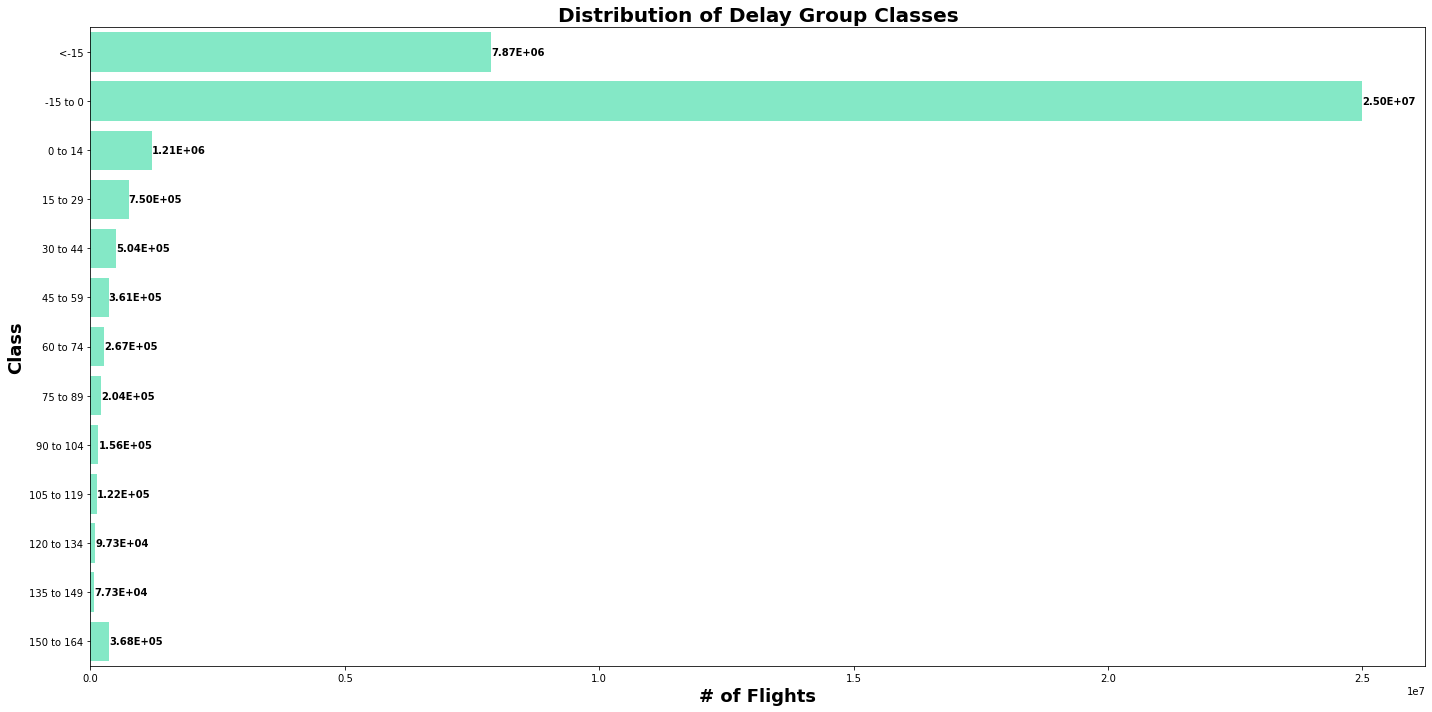

In [0]:
# Plot the distribution of flights in the different delay group classes
fig, ax = plt.subplots(figsize=(20, 10))
colors = {0.0: BACKGROUND, 1.0: FOREGROUND}
delay_label_counts.sort_values(by="DEP_DELAY_GROUP", ascending=True, inplace=True)
sns.barplot(
    data=delay_label_counts, y="DELAY_LABEL", x="flight_count", color=FOREGROUND
)
ax.bar_label(ax.containers[0], fmt="%.2E", fontweight="bold")
ax.set_title(
    "Distribution of Delay Group Classes",
    fontdict={"fontsize": 20, "fontweight": "bold"},
)
ax.set_xlabel("# of Flights", fontdict={"fontsize": 18, "fontweight": "bold"})
ax.set_ylabel("Class", fontdict={"fontsize": 18, "fontweight": "bold"})
fig.tight_layout()

**Load the pre-joined data from the BLOB container**

In [0]:
data = spark.read.parquet(f"{blob_url}/final_data_24nov")

# dbutils.data.summarize(data)

In [0]:
# display(data)

_utc_dept_ts _utc_dept_minus2_ts _utc_dept_actual_ts _utc_arr_ts _utc_arr_actual_ts _dep_time_str _local_dept_ts _local_dept_minus2_ts _local_dept_actual_ts _local_at_src_airport_arr_ts _local_at_src_airport_arr_actual_ts QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP origin_airport_iata origin_airport_tz origin_airport_type origin_airport_elevation origin_airport_iso_country origin_airport_iso_region origin_airport_ws_station_id dest_airport_iata dest_airport_tz dest_airport_type dest_airport_elevation dest_airport_iso_country dest_airport_iso_region dest_airport_ws_station_id origin_weather_Station origin_weather_Datehour origin_weather_Avg_Elevation origin_weather_Avg_HourlyAltimeterSetting origin_weather_Avg_HourlyDewPointTemperature origin_weather_Avg_HourlyDryBulbTemperature origin_weather_Avg_HourlyRelativeHumidity origin_weather_Avg_HourlySeaLevelPressure origin_weather_Avg_HourlyStationPressure origin_weather_Avg_HourlyVisibility origin_weather_Avg_HourlyWetBulbTemperature origin_weather_Avg_HourlyWindDirection origin_weather_Avg_HourlyWindSpeed origin_weather_Avg_Precip_Double origin_weather_Trace_Rain origin_weather_NonZero_Rain origin_weather_HourlyPressureTendency_Increasing origin_weather_HourlyPressureTendency_Decreasing origin_weather_HourlyPressureTendency_Constant origin_weather_Calm_Winds origin_weather_Sky_Conditions_CLR origin_weather_Sky_Conditions_FEW origin_weather_Sky_Conditions_SCT origin_weather_Sky_Conditions_BKN origin_weather_Sky_Conditions_OVC origin_weather_Sky_Conditions_VV origin_weather_Present_Weather_Drizzle origin_weather_Present_Weather_Rain origin_weather_Present_Weather_Snow origin_weather_Present_Weather_SnowGrains origin_weather_Present_Weather_IceCrystals origin_weather_Present_Weather_Hail origin_weather_Present_Weather_Mist origin_weather_Present_Weather_Fog origin_weather_Present_Weather_Smoke origin_weather_Present_Weather_Dust origin_weather_Present_Weather_Haze origin_weather_Present_Weather_Storm dest_weather_Station dest_weather_Datehour dest_weather_Avg_Elevation dest_weather_Avg_HourlyAltimeterSetting dest_weather_Avg_HourlyDewPointTemperature dest_weather_Avg_HourlyDryBulbTemperature dest_weather_Avg_HourlyRelativeHumidity dest_weather_Avg_HourlySeaLevelPressure dest_weather_Avg_HourlyStationPressure dest_weather_Avg_HourlyVisibility dest_weather_Avg_HourlyWetBulbTemperature dest_weather_Avg_HourlyWindDirection dest_weather_Avg_HourlyWindSpeed dest_weather_Avg_Precip_Double dest_weather_Trace_Rain dest_weather_NonZero_Rain dest_weather_HourlyPressureTendency_Increasing dest_weather_HourlyPressureTendency_Decreasing dest_weather_HourlyPressureTendency_Constant dest_weather_Calm_Winds dest_weather_Sky_Conditions_CLR dest_weather_Sky_Conditions_FEW dest_weather_Sky_Conditions_SCT dest_weather_Sky_Conditions_BKN dest_weather_Sky_Conditions_OVC dest_weather_Sky_Conditions_VV dest_weather_Present_Weather_Drizzle dest_weather_Present_Weather_Rain dest_weather_Present_Weather_Snow dest_weather_Present_Weather_SnowGrains dest_weather_Present_Weather_IceCrystals dest_weather_Present_Weather_Hail dest_weather_Present_Weather_Mist dest_weather_Present_Weather_Fog dest_weather_Present_Weather_Smoke dest_weather_Present_Weather_Dust dest_weather_Present_Weather_Haze dest_weather_Present_Weather_Storm DELAY_LABEL origin_traffic traffic_dat

### Correlation Matrix

The correlation matrix shows that the output variables, dep_delay or dep_delay_new, are not strongly correlated with any of the potential features for this study, such as hourly precipitation, hourly visibility, hourly wind direction, thunderstorm, heavy fog, etc. They all have very weak correlation, which are far less than 0.2.

In [0]:
# drop timestamp and string features
data = data.drop(
    "_utc_dept_ts",
    "_utc_dept_minus2_ts",
    "_utc_dept_actual_ts",
    "_utc_arr_ts",
    "_utc_arr_actual_ts",
    "_dep_time_str",
    "_local_dept_ts",
    "_local_dept_minus2_ts",
    "_local_dept_actual_ts",
    "_local_at_src_airport_arr_ts",
    "_local_at_src_airport_arr_actual_ts",
    "OP_UNIQUE_CARRIER",
    "OP_CARRIER",
    "ORIGIN_CITY_NAME",
    "ORIGIN_STATE_ABR",
    "ORIGIN_STATE_NM",
    "DEST_CITY_NAME",
    "DEST_STATE_ABR",
    "DEST_STATE_NM",
    "DEP_TIME_BLK",
    "ARR_TIME_BLK",
    "origin_airport_iata",
    "origin_airport_tz",
    "origin_airport_type",
    "origin_airport_elevation",
    "origin_airport_iso_country",
    "origin_airport_iso_region",
    "origin_airport_ws_station_id",
    "dest_airport_iata",
    "dest_airport_tz",
    "dest_airport_type",
    "dest_airport_elevation",
    "dest_airport_iso_country",
    "dest_airport_iso_region",
    "dest_airport_ws_station_id",
    "origin_weather_Station",
    "origin_weather_Datehour",
    "dest_weather_Station",
    "dest_weather_Datehour",
    "DELAY_LABEL",
    "origin_traffic",
    "traffic_date",
    "FL_DATE",
    "TAIL_NUM",
    "ORIGIN",
    "DEST",
)

# drop non-physical features
data = data.drop(
    "DAY_OF_MONTH",
    "OP_CARRIER_AIRLINE_ID",
    "OP_CARRIER_FL_NUM",
    "ORIGIN_AIRPORT_ID",
    "ORIGIN_AIRPORT_SEQ_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "_utc_dept_ts",
    "_utc_dept_minus2_ts",
    "_utc_dept_actual_ts",
    "_utc_dept_ts",
    "_utc_dept_minus2_ts",
    "_utc_dept_actual_ts",
    "_utc_arr_ts",
    "_utc_arr_actual_ts",
    "_dep_time_str",
    "_local_dept_ts",
    "_local_dept_minus2_ts",
    "_local_dept_actual_ts",
    "_local_at_src_airport_arr_ts",
    "_utc_dept_ts",
    "_utc_dept_minus2_ts",
    "_local_dept_actual_ts",
    "_local_at_src_airport_arr_ts",
    "FL_DATE",
    "DEST_AIRPORT_ID",
    "DEST_AIRPORT_SEQ_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
    "CRS_DEP_TIME",
    "DEP_TIME",
    "DEP_DELAY",
    "DEP_DELAY_GROUP",
    "TAXI_IN",
    "TAXI_OUT",
    "CRS_ARR_TIME",
    "WHEELS_OFF",
    "WHEELS_ON",
    "TAXI_IN" "CRS_ARR_TIME",
    "ARR_TIME",
    "ARR_DELAY",
    "ARR_DELAY_NEW",
    "ARR_DEL15",
    "ARR_DELAY_GROUP",
    "CANCELLED",
    "DIVERTED",
    "CRS_ELAPSED_TIME",
    "ACTUAL_ELAPSED_TIME",
    "AIR_TIME",
    "DISTANCE_GROUP",
    "traffic",
    "dest_weather_HourlyPressureTendency_Constant",
    "dest_weather_HourlyPressureTendency_Decreasing",
    "origin_weather_Present_Weather_SnowGrains",
    "origin_weather_HourlyPressureTendency_Constant",
    "origin_weather_HourlyPressureTendency_Decreasing",
    "FLIGHTS",
    "origin_weather_Present_Weather_Hail",
    "dest_weather_Avg_HourlyWetBulbTemperature",
    "dest_weather_Sky_Conditions_SCT",
    "dest_weather_Present_Weather_Hail",
    "dest_weather_Present_Weather_Drizzle",
    "origin_weather_Avg_HourlyWindSpeed",
    "origin_weather_Present_Weather_Drizzle",
    "origin_weather_Sky_Conditions_FEW",
    "dest_weather_Present_Weather_SnowGrains",
    "dest_weather_HourlyPressureTendency_Increasing",
    "origin_weather_Calm_Winds",
    "dest_weather_Present_Weather_IceCrystals",
    "origin_weather_Present_Weather_IceCrystals",
    "dest_weather_Calm_Winds",
    "origin_weather_Present_Weather_Haze",
    "origin_weather_Present_Weather_Dust",
    "origin_weather_Present_Weather_Smoke",
    "dest_weather_Present_Weather_Haze",
    "dest_weather_Present_Weather_Dust,origin_weather_Avg_HourlyStationPressure",
    "dest_weather_Present_Weather_Smoke",
    "origin_weather_Avg_Elevation",
)

# data2.printSchema()

In [0]:
# Correlation Matrix for the Joined Data
# Source URL: https://stackoverflow.com/questions/55546467/how-to-plot-correlation-heatmap-when-using-pysparkdatabricks
columns = data.columns
myGraph = data
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data.columns, outputCol=vector_col)
myGraph_vector = assembler.transform(myGraph).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
df_corr = spark.createDataFrame(corrmatrix, columns)

df_corr = df_corr.toPandas()
df_corr["Features"] = df_corr.columns
cols = df_corr.columns.tolist()
cols = cols[-1:] + cols[:-1]
display(df_corr[cols])

Features QUARTER MONTH DAY_OF_WEEK DEP_DELAY_NEW DEP_DEL15 DISTANCE origin_weather_Avg_HourlyAltimeterSetting origin_weather_Avg_HourlyDewPointTemperature origin_weather_Avg_HourlyDryBulbTemperature origin_weather_Avg_HourlyRelativeHumidity origin_weather_Avg_HourlySeaLevelPressure origin_weather_Avg_HourlyStationPressure origin_weather_Avg_HourlyVisibility origin_weather_Avg_HourlyWetBulbTemperature origin_weather_Avg_HourlyWindDirection origin_weather_Avg_Precip_Double origin_weather_Trace_Rain origin_weather_NonZero_Rain origin_weather_HourlyPressureTendency_Increasing origin_weather_Sky_Conditions_CLR origin_weather_Sky_Conditions_SCT origin_weather_Sky_Conditions_BKN origin_weather_Sky_Conditions_OVC origin_weather_Sky_Conditions_VV origin_weather_Present_Weather_Rain origin_weather_Present_Weather_Snow origin_weather_Present_Weather_Mist origin_weather_Present_Weather_Fog origin_weather_Present_Weather_Storm dest_weather_Avg_Elevation dest_weather_Avg_HourlyAltimeterSetting dest_weather_Avg_HourlyDewPointTemperature dest_weather_Avg_HourlyDryBulbTemperature dest_weather_Avg_HourlyRelativeHumidity dest_weather_Avg_HourlySeaLevelPressure dest_weather_Avg_HourlyStationPressure dest_weather_Avg_HourlyVisibility dest_weather_Avg_HourlyWindDirection dest_weather_Avg_HourlyWindSpeed dest_weather_Avg_Precip_Double dest_weather_Trace_Rain dest_weather_NonZero_Rain dest_weather_Sky_Conditions_CLR dest_weather_Sky_Conditions_FEW dest_weather_Sky_Conditions_BKN dest_weather_Sky_Conditions_OVC dest_weather_Sky_Conditions_VV dest_weather_Present_Weather_Rain dest_weather_Present_Weather_Snow dest_weather_Present_Weather_Mist dest_weather_Present_Weather_Fog dest_weather_Present_Weather_Dust dest_weather_Present_Weather_Storm volume_sigma delays_last_4_hrs inbound_dep_delay_time year QUARTER 1.0 0.9717393747934974 0.0039119548801162685 -0.003986916878437459 -0.0043687444088729415 0.0033040952952139275 -0.03395482091197536 0.18577779562867758 0.174923909899261 0.03540605417377617 -0.04978722479001896 -0.007894044291990155 0.034408934489768915 0.19014222864591468 -0.03727579269407152 0.003928376814925538 -0.03047425775620948 -0.03057768123264691 2.031677572176507E-4 0.03270738222178185 0.005100150227253366 -0.026755768726712603 -0.05962362732465659 -0.015380465875553615 -0.005778579542644368 -0.05952935561993842 -0.025781954745087703 -0.008796251660835721 0.0075026632731045135 0.0028230710390097875 -0.0337446685696199 0.18547654239484448 0.17463577685796458 0.03504396510332317 -0.04964986428505464 -0.00792460883341874 0.034308683314205064 -0.03665401585026139 -0.08031221523778147 0.003817815214431418 -0.03127664368975141 -0.031123185675012714 0.0327807257204059 0.015416895683550346 -0.026040892219772082 -0.059774574925885095 -0.01433990104158642 -0.006211898242247852 -0.0585624957372207 -0.025647967870712204 -0.009361537337301582 0.012380430697913378 0.007879375004780089 0.009396377611084122 -0.0069549847257311245 -0.002701422277881504 0.008857621333674926 MONTH 0.9717393747934974 1.0 0.004390532458276406 -0.00363190579883448 -0.003008841000066234 0.0039440904863599115 -0.033357688097790564 0.18198442254015182 0.1713731861195598 0.03545603445720764 -0.04903919316551708 -0.007960412743285019 0.0329685510695471 0.1865131713955087 -0.03930284226295874 0.003623486958809457 -0.03006684940348026 -0.030094331509944318 3.575350185968996E-5 0.029705578702397078 0.005304742103206267 -0.0243813924937941 -0.05692812210834664 -0.014081392329562842 -0.005542320927055744 -0.05945512931925228 -0.025046511085299844 -0.007692914283306657 0.006848705691793944 0.0029602959657141514 -0.033171414284555986 0.18171535576983547 0.17107370312811193 0.03518160919806595 -0.048913672964140564 -0.007941369991379479 0.03275079237505136 -0.038725989218478564 -0.07970014618842262 0.00361303372721853 -0.03085833667320367 -0.03063066502105707 0.029886607004189356 0.015523711426444186 -0.023646811560777966 -0.057002860380038316 -0.013174485455657445 -0.005871787341445528 -

Out[54]: Text(0.5, 1.0, 'Correlation Matrix')

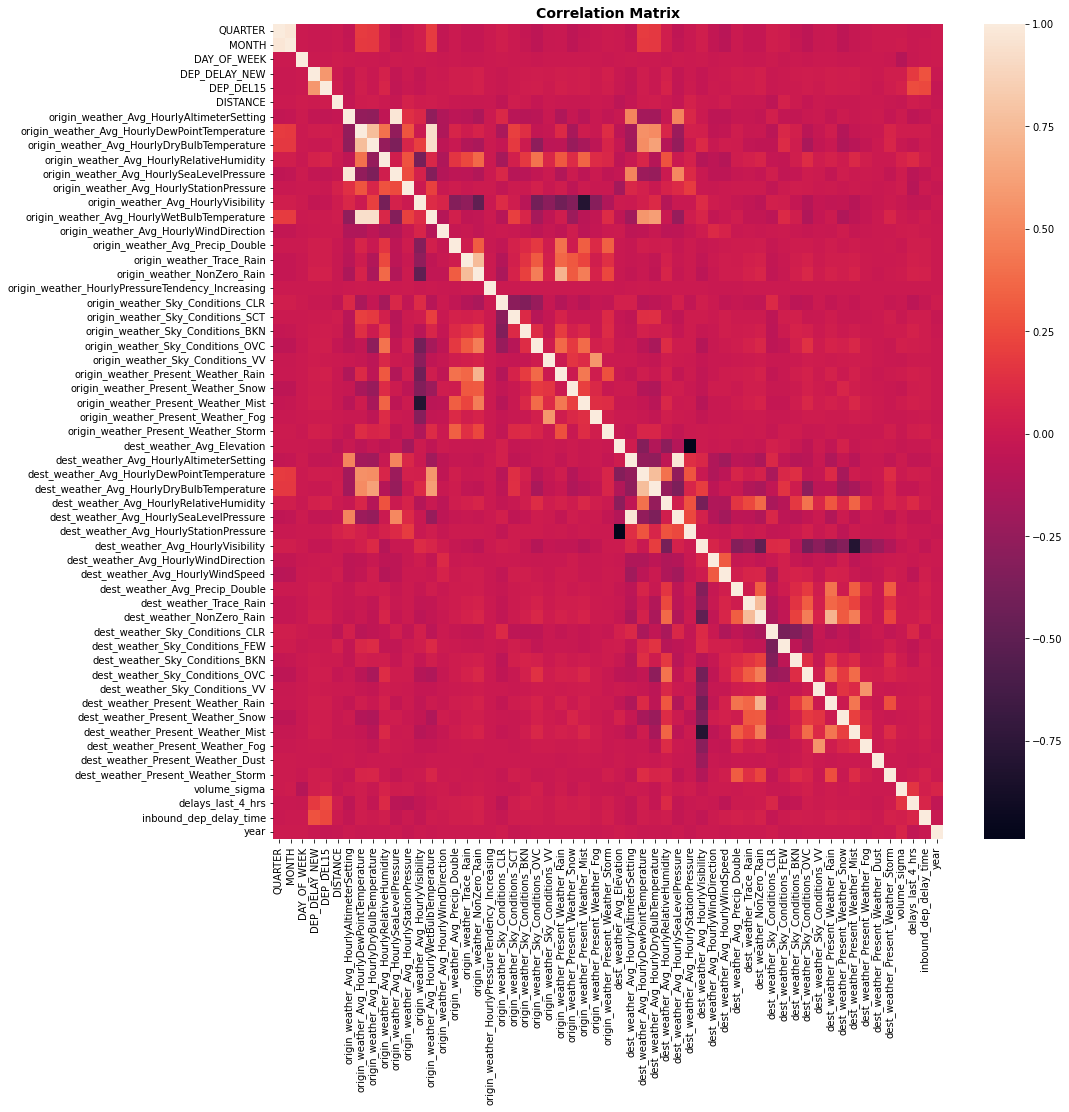

In [0]:
fig, ax = plt.subplots(figsize=(15, 15))
corr_plot = sns.heatmap(corrmatrix, yticklabels=columns, xticklabels=columns)
ax.set_title("Correlation Matrix", fontdict={"fontsize": 14, "fontweight": "bold"})

feature correlation origin_weather_Avg_HourlyAltimeterSetting -0.038968674310134 dest_weather_Avg_HourlyAltimeterSetting -0.0374251537628904 origin_weather_Avg_HourlySeaLevelPressure -0.0366257700355149 origin_weather_Avg_HourlyVisibility -0.03548775150524883 dest_weather_Avg_HourlySeaLevelPressure -0.03504715368133548 dest_weather_Avg_HourlyVisibility -0.03351688313355275 origin_weather_Sky_Conditions_CLR -0.0121277808672565 dest_weather_Sky_Conditions_CLR -0.009380953093526006 year -0.008530038453442402 dest_weather_Avg_Elevation -0.008200033068671937 dest_weather_Avg_HourlyDryBulbTemperature -0.007465335675706932 origin_weather_Avg_HourlyDryBulbTemperature -0.007297088969162771 QUARTER -0.003986916878437459 MONTH -0.00363190579883448 origin_weather_Avg_HourlyStationPressure -0.0024098730664221793 dest_weather_Present_Weather_Dust -0.0023256568899845094 DAY_OF_WEEK -9.819014143380921E-4 origin_weather_HourlyPressureTendency_Increasing 0.0019792700213078283 dest_weather_Avg_HourlyStationPressure 0.0033568289081758315 dest_weather_Avg_HourlyWindDirection 0.004475917345580232 dest_weather_Sky_Conditions_FEW 0.004689491382917286 origin_weather_Avg_HourlyWindDirection 0.0049958487805465985 DISTANCE 0.009724670137137039 origin_weather_Avg_HourlyWetBulbTemperature 0.009957335949549588 dest_weather_Avg_HourlyWindSpeed 0.01009079822447485 origin_weather_Present_Weather_Fog 0.011401808209492515 origin_weather_Sky_Conditions_SCT 0.011837457567241798 dest_weather_Present_Weather_Fog 0.012654464306967723 origin_weather_Sky_Conditions_VV 0.013363372905876615 dest_weather_Sky_Conditions_VV 0.015262356352312195 dest_weather_Sky_Conditions_BKN 0.01566730684050535 origin_weather_Sky_Conditions_BKN 0.019417649252145737 dest_weather_Avg_HourlyDewPointTemperature 0.021770337969104436 dest_weather_Present_Weather_Snow 0.023190030266828806 origin_weather_Avg_HourlyDewPointTemperature 0.02474101021873769 dest_weather_Sky_Conditions_OVC 0.025007387413654634 dest_weather_Trace_Rain 0.025509262742622822 origin_weather_Present_Weather_Snow 0.02796556108414165 origin_weather_Sky_Conditions_OVC 0.028455143111883987 dest_weather_Present_Weather_Mist 0.029283967404305063 origin_weather_Trace_Rain 0.03017434245847835 dest_weather_Avg_Precip_Double 0.03066287340858646 volume_sigma 0.03116285152094847 origin_weather_Present_Weather_Mist 0.031409100988918186 dest_weather_Present_Weather_Storm 0.03247301314398977 dest_weather_Present_Weather_Rain 0.032818032662185144 origin_weather_Avg_Precip_Double 0.032871042279338784 origin_weather_Present_Weather_Rain 0.036217085590229924 origin_weather_Present_Weather_Storm 0.036704354894138064 dest_weather_NonZero_Rain 0.042666049606377335 origin_weather_NonZero_Rain 0.04945514577908173 dest_weather_Avg_HourlyRelativeHumidity 0.05181787617648699 origin_weather_Avg_HourlyRelativeHumidity 0.05785976753928057 delays_last_4_hrs 0.17684479110328474 inbound_dep_delay_time 0.28431527974844345 DEP_DEL15 0.5751169358032856 DEP_DELAY_NEW 1.0

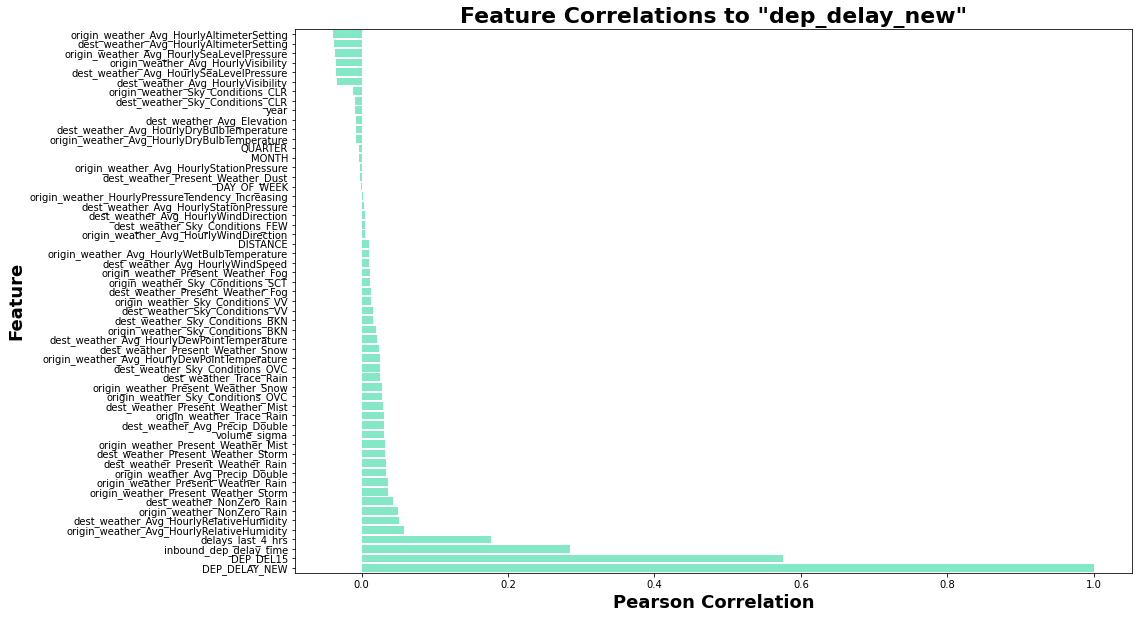

In [0]:
dep_delay_correlations = pd.DataFrame(
    list(zip(columns, corrmatrix[3])), columns=["feature", "correlation"]
)
dep_delay_correlations = dep_delay_correlations[
    ~dep_delay_correlations.feature.isin(
        ["dep_delay_new", "dep_delay", "dep_delay_group", "dep_del15"]
    )
]
dep_delay_correlations.sort_values(by="correlation", inplace=True)
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(
    data=dep_delay_correlations, y="feature", x="correlation", color=FOREGROUND, ax=ax
)
ax.set_title(
    'Feature Correlations to "dep_delay_new"',
    fontdict={"fontsize": 22, "fontweight": "bold"},
)
ax.set_xlabel("Pearson Correlation", fontdict={"fontsize": 18, "fontweight": "bold"})
ax.set_ylabel("Feature", fontdict={"fontsize": 18, "fontweight": "bold"})
display(dep_delay_correlations)

feature correlation origin_weather_Avg_HourlyAltimeterSetting -0.04870445900881351 origin_weather_Avg_HourlySeaLevelPressure -0.04692438898787811 dest_weather_Avg_HourlyAltimeterSetting -0.046252443236917115 dest_weather_Avg_HourlySeaLevelPressure -0.04371903795108176 origin_weather_Avg_HourlyVisibility -0.03336331787122451 year -0.02906769988210865 dest_weather_Avg_HourlyVisibility -0.028214575446292998 origin_weather_Sky_Conditions_CLR -0.016245537750678746 dest_weather_Avg_Elevation -0.013730542156409453 dest_weather_Avg_HourlyDryBulbTemperature -0.00959680076541298 origin_weather_Avg_HourlyDryBulbTemperature -0.008959550470060182 QUARTER -0.0043687444088729415 dest_weather_Present_Weather_Dust -0.0038794300947624285 dest_weather_Sky_Conditions_CLR -0.003692806648751666 origin_weather_Avg_HourlyStationPressure -0.0030844999407024032 MONTH -0.003008841000066234 DAY_OF_WEEK 9.984235678482882E-4 dest_weather_Sky_Conditions_FEW 0.0015908178600064756 dest_weather_Avg_HourlyWindSpeed 0.0021337065225848916 origin_weather_HourlyPressureTendency_Increasing 0.0029979011273467333 dest_weather_Avg_HourlyWindDirection 0.005710573356421119 origin_weather_Avg_HourlyWindDirection 0.006658622078769587 origin_weather_Present_Weather_Fog 0.007228488057501367 dest_weather_Avg_HourlyStationPressure 0.007621846015719419 dest_weather_Present_Weather_Fog 0.007846577036814805 dest_weather_Sky_Conditions_VV 0.009776168133892973 origin_weather_Sky_Conditions_VV 0.01004170226969812 origin_weather_Avg_HourlyWetBulbTemperature 0.011397549323151169 origin_weather_Sky_Conditions_SCT 0.012634722666723492 dest_weather_Sky_Conditions_BKN 0.012966018486837705 DISTANCE 0.02040570177665647 dest_weather_Present_Weather_Snow 0.020995641939933928 origin_weather_Sky_Conditions_BKN 0.022008273705765326 dest_weather_Avg_Precip_Double 0.02431451138850856 dest_weather_Avg_HourlyDewPointTemperature 0.024877050040034973 dest_weather_Trace_Rain 0.025932588306457754 dest_weather_Present_Weather_Storm 0.02598735440553364 dest_weather_Sky_Conditions_OVC 0.02621621230107635 origin_weather_Present_Weather_Snow 0.026384817615495725 dest_weather_Present_Weather_Mist 0.026533723964393918 origin_weather_Avg_HourlyDewPointTemperature 0.028696558611497898 origin_weather_Avg_Precip_Double 0.028737921741696464 origin_weather_Sky_Conditions_OVC 0.030627687020555783 dest_weather_Present_Weather_Rain 0.03105340146287842 origin_weather_Present_Weather_Mist 0.03108884818052586 origin_weather_Present_Weather_Storm 0.031996503311543925 origin_weather_Trace_Rain 0.03277768794674243 origin_weather_Present_Weather_Rain 0.036858437961159465 dest_weather_NonZero_Rain 0.04169243125398018 origin_weather_NonZero_Rain 0.05165956954363559 volume_sigma 0.0548339550279438 dest_weather_Avg_HourlyRelativeHumidity 0.061932115495759284 origin_weather_Avg_HourlyRelativeHumidity 0.06850819294352271 inbound_dep_delay_time 0.24421990921800404 delays_last_4_hrs 0.2584685838055531 DEP_DELAY_NEW 0.5751169358032856 DEP_DEL15 1.0

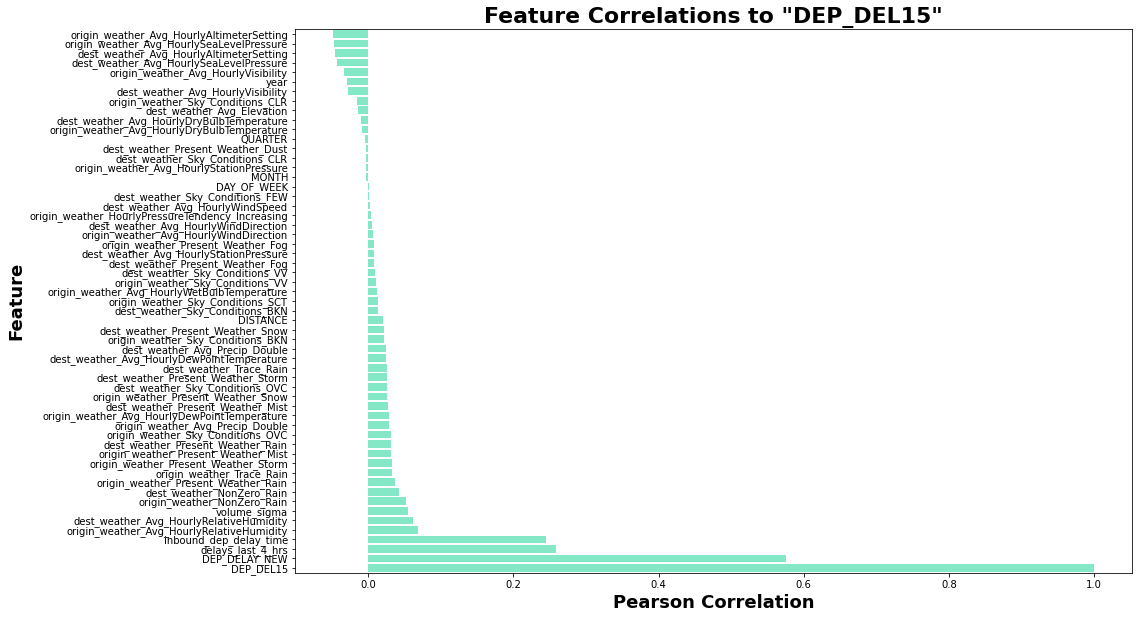

In [0]:
dep_delay_correlations = pd.DataFrame(
    list(zip(columns, corrmatrix[4])), columns=["feature", "correlation"]
)
dep_delay_correlations = dep_delay_correlations[
    ~dep_delay_correlations.feature.isin(
        ["dep_delay_new", "dep_delay", "dep_delay_group", "dep_del15"]
    )
]
dep_delay_correlations.sort_values(by="correlation", inplace=True)
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(
    data=dep_delay_correlations, y="feature", x="correlation", color=FOREGROUND, ax=ax
)
ax.set_title(
    'Feature Correlations to "DEP_DEL15"',
    fontdict={"fontsize": 22, "fontweight": "bold"},
)
ax.set_xlabel("Pearson Correlation", fontdict={"fontsize": 18, "fontweight": "bold"})
ax.set_ylabel("Feature", fontdict={"fontsize": 18, "fontweight": "bold"})
display(dep_delay_correlations)

In [0]:
# Split the joined data frame into year chunks to allow concatenating them as blocks as shown visually in the image above.
# The custom-cross validator is expecting a dictionary where each key is a different fold, and the key value is a dataframe with a column called 'cv' that designates rows
# As either train or split

series_folds = {
    "fold1": (["2015", "2016"], ["2017", "2018"]),
    "fold2": (["2015", "2016", "2017"], ["2018", "2019"]),
    "fold3": (["2015", "2016", "2017", "2018"], ["2019", "2020"]),
}
cross_validation_data = {}
for fold in series_folds.keys():
    train_years = series_folds[fold][0]
    val_years = series_folds[fold][1]
    cross_validation_data[fold] = (
        data.filter(data.year.isin(train_years + val_years))
        .withColumn(
            "cv", when(col("year").isin(train_years), "train").otherwise("test")
        )
        .cache()
    )

The mse of this baseline is given by the average of the obtained mse(s) which is approximately equal to 1929 (minutes).
This baseline model is applied for inference on the test_data.

In [0]:
test_data = data.filter(year(col("fl_date")) == "2021")
display(test_data)

fl_date day_of_week crs_dep_time_utc 2hr_pre_dep origin dest tail_num dep_delay dep_del15 dep_delay_new flights distance dep_delay_group tz traffic volume_sigma delays_last_4_hrs inbound_dep_delay_time latitude longitude elevation HourlyPrecipitation HourlyVisibility HourlyWindDirection HourlyWindGustSpeed HourlyWindSpeed HourlyPressureChange HourlyDryBulbTemperature thunderstorm heavy_fog hail dust_storm high_winds freezing_rain tornado year month 2021-01-01 5 2021-01-01T21:03:00.000+0000 2021-01-01T19:00:00 EYW ORD N640RW 103.0 1.0 103.0 1.0 1251.0 6 America/New_York 12 0.9440536336081607 3.0 81.0 24.55706 -81.75539 0.3 0.0 9.94 120.0 0.0 11.0 -0.01 74.0 0 0 0 0 0 0 0 2021 1 2021-01-01 5 2021-01-01T21:41:00.000+0000 2021-01-01T19:00:00 EYW PHL N9026C 12.0 0.0 12.0 1.0 1121.0 0 America/New_York 12 0.9440536336081607 3.0 2.0 24.55706 -81.75539 0.3 0.0 9.94 120.0 0.0 11.0 -0.01 74.0 0 0 0 0 0 0 0 2021 1 2021-01-22 5 2021-01-22T12:00:00.000+0000 2021-01-22T10:00:00 EYW MIA N114HQ -6.0 0.0 0.0 1.0 126.0 -1 America/New_York 10 0.6060413375174708 0.0 -7.0 24.55706 -81.75539 0.3 0.0 9.94 30.0 0.0 6.0 -0.05 75.0 0 0 0 0 0 0 0 2021 1 2021-02-02 2 2021-02-02T12:00:00.000+0000 2021-02-02T10:00:00 EYW ATL N234JQ -9.0 0.0 0.0 1.0 646.0 -1 America/New_York 15 1.4510720777441954 0.0 -6.0 24.55706 -81.75539 0.3 0.0 9.94 310.0 0.0 23.0 -0.05 64.0 0 0 0 0 0 0 0 2021 2 2021-03-05 5 2021-03-05T18:01:00.000+0000 2021-03-05T16:00:00 EYW ATL N371NB 1189.0 1.0 1189.0 1.0 646.0 12 America/New_York 21 2.465108966016265 1.0 -5.0 24.55706 -81.75539 0.3 0.0 9.94 10.0 0.0 8.0 0.05 77.0 0 0 0 0 0 0 0 2021 3 2021-03-05 5 2021-03-05T18:30:00.000+0000 2021-03-05T16:00:00 EYW DFW N9022G -13.0 0.0 0.0 1.0 1089.0 -1 America/New_York 21 2.465108966016265 1.0 10.0 24.55706 -81.75539 0.3 0.0 9.94 10.0 0.0 8.0 0.05 77.0 0 0 0 0 0 0 0 2021 3 2021-03-05 5 2021-03-05T18:50:00.000+0000 2021-03-05T16:00:00 EYW CLT N119HQ -11.0 0.0 0.0 1.0 736.0 -1 America/New_York 21 2.465108966016265 1.0 -1.0 24.55706 -81.75539 0.3 0.0 9.94 10.0 0.0 8.0 0.05 77.0 0 0 0 0 0 0 0 2021 3 2021-04-14 3 2021-04-14T18:15:00.000+0000 2021-04-14T16:00:00 EYW ORD N653RW -7.0 0.0 0.0 1.0 1251.0 -1 America/New_York 17 1.7890843738348854 3.0 -6.0 24.55706 -81.75539 0.3 0.0 9.94 120.0 0.0 14.0 0.04 81.0 0 0 0 0 0 0 0 2021 4 2021-04-24 6 2021-04-24T15:53:00.000+0000 2021-04-24T13:00:00 EYW DCA N450YX 8.0 0.0 8.0 1.0 1023.0 0 America/New_York 20 2.29610281797092 2.0 -5.0 24.55706 -81.75539 0.3 0.0 9.94 180.0 0.0 16.0 0.03 83.0 0 0 0 0 0 0 0 2021 4 2021-04-24 6 2021-04-24T15:45:00.000+0000 2021-04-24T13:00:00 EYW CLT N451YX 13.0 0.0 13.0 1.0 736.0 0 America/New_York 20 2.29610281797092 2.0 9.0 24.55706 -81.75539 0.3 0.0 9.94 180.0 0.0 16.0 0.03 83.0 0 0 0 0 0 0 0 2021 4 2021-04-24 6 2021-04-24T15:45:00.000+0000 2021-04-24T13:00:00 EYW EWR N648RW 15.0 1.0 15.0 1.0 1196.0 1 America/New_York 20 2.29610281797092 2.0 -8.0 24.55706 -81.75539 0.3 0.0 9.94 180.0 0.0 16.0 0.03 83.0 0 0 0 0 0 0 0 2021 4 2021-04-24 6 2021-04-24T15:13:00.000+0000 2021-04-24T13:00:00 EYW ATL N365NB 0.0 0.0 0.0 1.0 646.0 0 America/New_York 20 2.29610281797092 2.0 460.0 24.55706 -81.75539 0.3 0.0 9.94 180.0 0.0 16.0 0.03 83.0 0 0 0 0 0 0 0 2021 4 2021-05-04 2 2021-05-04T18:10:00.000+0000 2021-05-04T16:00:00 EYW LGA N218JQ 8.0 0.0 8.0 1.0 1207.0 0 America/New_York 22 2.6341151140616104 3.0 -7.0 24.55706 -81.75539 0.3 0.0 9.94 120.0 0.0 11.0 0.05 85.0 0 0 0 0 0 0 0 2021 5 2021-05-04 2 2021-05-04T18:15:00.000+0000 2021-05-04T16:00:00 EYW ORD N979RP -3.0 0.0 0.0 1.0 1251.0 -1 America/New_York 22 2.6341151140616104 3.0 -4.0 24.55706 -81.75539 0.3 0.0 9.94 120.0 0.0 11.0 0.05 85.0 0 0 0 0 0 0 0 2021 5 2021-07-24 6 2021-07-24T21:15:00.000+0000 2021-07-24T19:00:00 EYW IAH N85369 -5.0 0.0 0.0 1.0 915.0 -1 America/New_York 18 1.9580905218802303 8.0 69.0 24.55706 -81.75539 0.3 0.0 9.94 0.0 0.0 7.0 0.01 87.0 0 0 0 0 0 0 0 2021 7 2021-07-24 6 2021-07-24T21:25:00.000+0000 2021-07-24T19:00:00 EYW DCA N403YX 92.0 1.0 92.0 1.0 1023.0 6 America/New_York

In [0]:
test_modified = test_data.withColumn(
    "time_location", lit(concat_ws("_", month("fl_date"), "origin"))
)
joined = test_modified.join(
    fold3_agg, test_modified.time_location == fold3_agg.m_org_concat
)
test_mse = joined.withColumn(
    "error", (joined["dep_delay_new"] - joined["avg_delay"]) ** 2
).agg(mean("error").alias("mse"))
test_mse.show()

+------------------+
|               mse|
+------------------+
|2111.5453610565387|
+------------------+



**2. Linear Regression**

As a simple baseline we will start with ordinary linear regression across a few different feature sets and hyper-parameters. Linear regression probably a poor fit for this type of prediction task but it will serve as a starting point for building future pipelines. The parameter maps we will explore are described below:

In [0]:
def parameter_combinations(parameter_dict):
    parameter_list = list(parameter_dict.keys())
    return (parameter_list, list(itertools.product(*parameter_dict.values())))

In [0]:
def linear_regression_pipeline(feature_columns, label_column, parameters):
    feature_vector_assembler = VectorAssembler(
        inputCols=feature_columns, outputCol="features"
    )
    data_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    linear_regressor = LinearRegression(
        featuresCol="scaled_features",
        labelCol="DEP_DELAY_NEW",
        maxIter=parameters[0],
        regParam=parameters[1],
        elasticNetParam=parameters[2],
    )
    pipeline = Pipeline(
        stages=[feature_vector_assembler, data_scaler, linear_regressor]
    )
    return pipeline

In [0]:
def TimeSeriesCrossValidator(
    input_data, feature_columns, label_column, pipeline_type, parameter_combinations
):
    """Expects a dictionary where each key is a fold and value is a dataframe of training/test data with training/test rows identified by a column called 'cv'."""
    if pipeline_type == "linear_regression":
        print(f"Running {pipeline_type}")
        pipe_path = linear_regression_pipeline
    elif pipeline_type == "decision_tree_regression":
        print(f"Running {pipeline_type}")
        pipe_path = decision_tree_pipeline
    elif pipeline_type == "random_forest_regression":
        print(f"Running {pipeline_type}")
        pipe_path = random_forest_pipeline
    elif pipeline_type == "gradient_boosted_tree_regression":
        print(f"Running {pipeline_type}")
        pipe_path = gbTress_pipeline

    parameter_names = parameter_combinations[0]
    parameter_values = parameter_combinations[1]
    best_parameters = None
    lowest_loss = None

    for parameters in parameter_values:
        pipeline = pipe_path(feature_columns, label_column, parameters)
        fold_losses = []
        for fold in input_data.keys():
            train_data = input_data[fold].filter(col("cv") == "train")
            test_data = input_data[fold].filter(col("cv") == "test")
            model = pipeline.fit(train_data)

            predictions = model.transform(test_data)
            evaluator = RegressionEvaluator(labelCol=label_column)
            mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})

            fold_losses.append(mse)
            print(f"{fold}: {mse}")

        mean_loss = np.mean(fold_losses)
        if not lowest_loss:
            lowest_loss = mean_loss

        if mean_loss <= lowest_loss:
            lowest_loss = mean_loss
            best_parameters = parameters
            parameter_string = {
                parameter_names[ii]: parameters[ii]
                for ii in range(len(parameter_names))
            }
            print(f"Lowest loss(mse): {lowest_loss}\nParmeters:{parameter_string}")
    return best_parameters, lowest_loss, lowest_loss**0.5

In [0]:
feature_columns = [
    "origin_weather_Avg_HourlyRelativeHumidity",
    "origin_weather_NonZero_Rain",
    "origin_weather_Present_Weather_Storm",
    "origin_weather_Present_Weather_Rain",
    "origin_weather_Avg_Precip_Double",
    "origin_weather_Present_Weather_Mist",
    "origin_weather_Trace_Rain",
    "origin_weather_Sky_Conditions_OVC",
    "origin_weather_Present_Weather_Snow",
    "origin_weather_Avg_HourlyDewPointTemperature",
    "origin_weather_Sky_Conditions_BKN",
    "origin_weather_Sky_Conditions_VV",
    "origin_weather_Sky_Conditions_SCT",
    "origin_weather_Present_Weather_Fog",
    "origin_weather_Avg_HourlyAltimeterSetting",
    "origin_weather_Avg_HourlySeaLevelPressure",
    "origin_weather_Avg_HourlyVisibility",
    "origin_weather_Sky_Conditions_CLR",
]

# First create a parameter grid we want to explore for hyper-tunining the linear regression model.
lr_parameters = {
    "maxIter": [5, 10, 20],
    "regParam": [0, 0.01, 0.1],
    "elasticNetParam": [0, 1],
}
lr_param_combos = parameter_combinations(lr_parameters)
results = TimeSeriesCrossValidator(
    cross_validation_data,
    feature_columns,
    "DEP_DELAY_NEW",
    "linear_regression",
    lr_param_combos,
)
print(
    f"Linear Regresssion best params: {results[0]}, lowest loss(MSE): {results[1]}, lowest loss(RMSE): {results[2]}"
)

Running linear_regression
fold1: 1869.42221255058
fold2: 2104.4205612909595
fold3: 1894.8179071328036
Lowest loss(mse): 1956.2202269914476
Parmeters:{'maxIter': 5, 'regParam': 0, 'elasticNetParam': 0}
fold1: 1869.42221255058
fold2: 2104.4205612909595
fold3: 1894.817907132803
Lowest loss(mse): 1956.2202269914476
Parmeters:{'maxIter': 5, 'regParam': 0, 'elasticNetParam': 1}
fold1: 1869.4227696957148
fold2: 2104.4227448397796
fold3: 1894.8170628207954
fold1: 1869.8026322199432
fold2: 2104.949437909269
fold3: 1895.5951171190025
fold1: 1869.4289409461758
fold2: 2104.442115325191
fold3: 1894.8124861563788
fold1: 1869.9470441899755
fold2: 2105.0994919829113
fold3: 1895.7114163644085
fold1: 1869.42221255058
fold2: 2104.4205612909595
fold3: 1894.817907132803
Lowest loss(mse): 1956.2202269914476
Parmeters:{'maxIter': 10, 'regParam': 0, 'elasticNetParam': 0}
fold1: 1869.42221255058
fold2: 2104.4205612909595
fold3: 1894.817907132803
Lowest loss(mse): 1956.2202269914476
Parmeters:{'maxIter': 10, 'r

**3. Decision Tree**

In [0]:
# source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.DecisionTreeRegressor.html
# https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-regression


def decision_tree_pipeline(feature_columns, label_column, parameters):

    feature_vector_assembler = VectorAssembler(
        inputCols=feature_columns, outputCol="features"
    )

    dt_regressor = DecisionTreeRegressor(
        featuresCol="features",
        labelCol="DEP_DELAY_NEW",
        maxDepth=parameters[0],
        maxBins=parameters[1],
    )
    pipeline = Pipeline(stages=[feature_vector_assembler, dt_regressor])
    return pipeline

In [0]:
feature_columns = [
    "origin_weather_Avg_HourlyRelativeHumidity",
    "origin_weather_NonZero_Rain",
    "origin_weather_Present_Weather_Storm",
    "origin_weather_Present_Weather_Rain",
    "origin_weather_Avg_Precip_Double",
    "origin_weather_Present_Weather_Mist",
    "origin_weather_Trace_Rain",
    "origin_weather_Sky_Conditions_OVC",
    "origin_weather_Present_Weather_Snow",
    "origin_weather_Avg_HourlyDewPointTemperature",
    "origin_weather_Sky_Conditions_BKN",
    "origin_weather_Sky_Conditions_VV",
    "origin_weather_Sky_Conditions_SCT",
    "origin_weather_Present_Weather_Fog",
    "origin_weather_Avg_HourlyAltimeterSetting",
    "origin_weather_Avg_HourlySeaLevelPressure",
    "origin_weather_Avg_HourlyVisibility",
    "origin_weather_Sky_Conditions_CLR",
]

decision_tree_parameters = {"maxDepth": [5, 10, 15], "maxBins": [8, 16, 32]}
decision_tree_param_combos = parameter_combinations(decision_tree_parameters)
results = TimeSeriesCrossValidator(
    cross_validation_data,
    feature_columns,
    "DEP_DELAY_NEW",
    "decision_tree_regression",
    decision_tree_param_combos,
)

print(
    f"Decision Tree regression best params: {results[0]}, lowest loss(MSE): {results[1]}, lowest loss(RMSE): {results[2]}"
)

Running decision_tree_regression
fold1: 1867.07149599878
fold2: 2102.0906480141293
fold3: 1893.6935512974387
Lowest loss(mse): 1954.285231770116
Parmeters:{'maxDepth': 5, 'maxBins': 8}
fold1: 1866.6297996908631
fold2: 2101.72646649523
fold3: 1893.3677011520392
Lowest loss(mse): 1953.907989112711
Parmeters:{'maxDepth': 5, 'maxBins': 16}
fold1: 1866.9161449918238
fold2: 2101.695133829354
fold3: 1892.9594423964961
Lowest loss(mse): 1953.856907072558
Parmeters:{'maxDepth': 5, 'maxBins': 32}
fold1: 1869.6013169243993
fold2: 2104.7315994173287
fold3: 1893.0635295199597
fold1: 1868.9689538717264
fold2: 2100.380365187045
fold3: 1891.874651619914
Lowest loss(mse): 1953.741323559562
Parmeters:{'maxDepth': 10, 'maxBins': 16}
fold1: 1869.5902842907221
fold2: 2103.345363014367
fold3: 1894.5680825925592
fold1: 1911.8541525933415
fold2: 2137.6693208538195
fold3: 1918.5528241374116
fold1: 1934.2824926844455
fold2: 2162.2465199214225
fold3: 1931.135336060025
fold1: 1946.32871859999
fold2: 2159.77127851

**4. Random Forest (regression tree)**

In [0]:
# source: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html
def random_forest_pipeline(feature_columns, label_column, parameters):

    feature_vector_assembler = VectorAssembler(
        inputCols=feature_columns, outputCol="features"
    )

    rf_regressor = RandomForestRegressor(
        featuresCol="features",
        labelCol="DEP_DELAY_NEW",
        maxDepth=parameters[0],
        maxBins=parameters[1],
        numTrees=parameters[2],
    )
    pipeline = Pipeline(stages=[feature_vector_assembler, rf_regressor])
    return pipeline

In [0]:
feature_columns = [
    "origin_weather_Avg_HourlyRelativeHumidity",
    "origin_weather_NonZero_Rain",
    "origin_weather_Present_Weather_Storm",
    "origin_weather_Present_Weather_Rain",
    "origin_weather_Avg_Precip_Double",
    "origin_weather_Present_Weather_Mist",
    "origin_weather_Trace_Rain",
    "origin_weather_Sky_Conditions_OVC",
    "origin_weather_Present_Weather_Snow",
    "origin_weather_Avg_HourlyDewPointTemperature",
    "origin_weather_Sky_Conditions_BKN",
    "origin_weather_Sky_Conditions_VV",
    "origin_weather_Sky_Conditions_SCT",
    "origin_weather_Present_Weather_Fog",
    "origin_weather_Avg_HourlyAltimeterSetting",
    "origin_weather_Avg_HourlySeaLevelPressure",
    "origin_weather_Avg_HourlyVisibility",
    "origin_weather_Sky_Conditions_CLR",
]

random_forest_parameters = {
    "maxDepth": [5, 10, 15],
    "maxBins": [8, 16, 32],
    "numTrees": [20, 60, 100],
}
random_forest_param_combos = parameter_combinations(random_forest_parameters)
results = TimeSeriesCrossValidator(
    cross_validation_data,
    feature_columns,
    "DEP_DELAY_NEW",
    "random_forest_regression",
    random_forest_param_combos,
)

print(
    f"Random Forest regression best params: {results[0]}, lowest loss(MSE): {results[1]}, lowest loss(RMSE): {results[2]}"
)

Running random_forest_regression
fold1: 1866.381317442144
fold2: 2101.728456673298
fold3: 1893.1179858276803
Lowest loss(mse): 1953.7425866477072
Parmeters:{'maxDepth': 5, 'maxBins': 8, 'numTrees': 20}
fold1: 1866.0580338000862
fold2: 2101.376644363813
fold3: 1892.9301585931175
Lowest loss(mse): 1953.4549455856722
Parmeters:{'maxDepth': 5, 'maxBins': 8, 'numTrees': 60}
fold1: 1866.2229387551124
fold2: 2101.547189970392
fold3: 1892.9607443919715
fold1: 1865.5779236370702
fold2: 2100.77789214223
fold3: 1892.331032939003
Lowest loss(mse): 1952.8956162394345
Parmeters:{'maxDepth': 5, 'maxBins': 16, 'numTrees': 20}
fold1: 1865.2979967583062
fold2: 2100.559574193818
fold3: 1892.2816134927555
Lowest loss(mse): 1952.7130614816267
Parmeters:{'maxDepth': 5, 'maxBins': 16, 'numTrees': 60}
fold1: 1865.4092236604124
fold2: 2100.6488945758256
fold3: 1892.3149950802497
fold1: 1865.4896875442075
fold2: 2100.6745003017722
fold3: 1892.234578062698
fold1: 1865.1903562224934
fold2: 2100.3337519604115
fold

**5. Gradient Boosted Trees**

In [0]:
def gbTress_pipeline(feature_columns, label_column, parameters):

    feature_vector_assembler = VectorAssembler(
        inputCols=feature_columns, outputCol="features"
    )

    gbt_regressor = GBTRegressor(
        featuresCol="features",
        labelCol="DEP_DELAY_NEW",
        maxDepth=parameters[0],
        maxBins=parameters[1],
        maxIter=parameters[2],
    )
    pipeline = Pipeline(stages=[feature_vector_assembler, gbt_regressor])
    return pipeline

In [0]:
feature_columns = [
    "origin_weather_Avg_HourlyRelativeHumidity",
    "origin_weather_NonZero_Rain",
    "origin_weather_Present_Weather_Storm",
    "origin_weather_Present_Weather_Rain",
    "origin_weather_Avg_Precip_Double",
    "origin_weather_Present_Weather_Mist",
    "origin_weather_Trace_Rain",
    "origin_weather_Sky_Conditions_OVC",
    "origin_weather_Present_Weather_Snow",
    "origin_weather_Avg_HourlyDewPointTemperature",
    "origin_weather_Sky_Conditions_BKN",
    "origin_weather_Sky_Conditions_VV",
    "origin_weather_Sky_Conditions_SCT",
    "origin_weather_Present_Weather_Fog",
    "origin_weather_Avg_HourlyAltimeterSetting",
    "origin_weather_Avg_HourlySeaLevelPressure",
    "origin_weather_Avg_HourlyVisibility",
    "origin_weather_Sky_Conditions_CLR",
]

gbTress_parameters = {
    "maxDepth": [5, 10, 15],
    "maxBins": [8, 16, 32],
    "maxIter": [10, 50, 100],
}

gbt_param_combos = parameter_combinations(gbTress_parameters)
results = TimeSeriesCrossValidator(
    cross_validation_data,
    feature_columns,
    "DEP_DELAY_NEW",
    "gradient_boosted_tree_regression",
    gbt_param_combos,
)
print(
    f"Gradient Boosted Tree regression best params: {results[0]}, lowest loss(MSE): {results[1]}, lowest loss(RMSE): {results[2]}"
)

Running gradient_boosted_tree_regression
fold1: 1864.1545490708836
fold2: 2098.5541541134503
fold3: 1891.3741007721885
Lowest loss(mse): 1951.3609346521741
Parmeters:{'maxDepth': 5, 'maxBins': 8, 'maxIter': 10}
fold1: 1862.9507146981232
fold2: 2096.557362036509
fold3: 1890.0224705625963
Lowest loss(mse): 1949.843515765743
Parmeters:{'maxDepth': 5, 'maxBins': 8, 'maxIter': 50}
fold1: 1863.2185874388456
fold2: 2096.183532292255
fold3: 1890.0958197651294
Lowest loss(mse): 1949.8326464987433
Parmeters:{'maxDepth': 5, 'maxBins': 8, 'maxIter': 100}
fold1: 1863.4476500423852
fold2: 2097.500409819604
fold3: 1890.0929387192152
fold1: 1862.0001150540177
fold2: 2094.836573134361
fold3: 1888.5299116720726
Lowest loss(mse): 1948.455533286817
Parmeters:{'maxDepth': 5, 'maxBins': 16, 'maxIter': 50}
fold1: 1862.1313408545952
fold2: 2094.7492503089775
fold3: 1888.3197292926168
Lowest loss(mse): 1948.40010681873
Parmeters:{'maxDepth': 5, 'maxBins': 16, 'maxIter': 100}
fold1: 1863.9477656779427
fold2: 20

### Regression Model Evaluation on Test Dataset

In [0]:
def evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
):
    """This function would evaluate the test data using the best parameters obtained from
    the time series cross validation.
    """
    print(f"Begin fitting pipeline on train dataset to create {model_type} model")
    if model_type == "linear_regression":
        pipeline = linear_regression_pipeline(feature_columns, label_column, parameters)

    elif model_type == "decision_tree_regression":
        pipeline = decision_tree_pipeline(feature_columns, label_column, parameters)

    elif model_type == "random_forest_regression":
        pipeline = random_forest_pipeline(feature_columns, label_column, parameters)

    elif model_type == "gradient_boosted_tree_regression":
        pipeline = gbTress_pipeline(feature_columns, label_column, parameters)

    model = pipeline.fit(train_data)
    print(
        "pipeline fit has been completed on the train data! Let's begin model transformation on the test data."
    )
    predictions = model.transform(test_data)

    print("Model transformation on test data completed! Now begin evaluation.")
    evaluator = RegressionEvaluator(labelCol=label_column)
    rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
    mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
    r_squared = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
    print("Evaluation completed!")
    print(f"Evaluation results for {model_type} are: ")
    print(f"RMSE: {rmse}, MSE: {mse}, R-SQUARED: {r_squared}")
    return model


# Run evaluation function. Remember to specify the model_type
feature_columns = [
    "inbound_dep_delay_time",
    "delays_last_4_hrs",
    "origin_weather_Avg_HourlyRelativeHumidity",
    "origin_weather_NonZero_Rain",
    "origin_weather_Present_Weather_Storm",
    "origin_weather_Present_Weather_Rain",
    "origin_weather_Avg_Precip_Double",
    "origin_weather_Present_Weather_Mist",
    "volume_sigma",
    "origin_weather_Trace_Rain",
    "origin_weather_Sky_Conditions_OVC",
    "origin_weather_Present_Weather_Snow",
    "origin_weather_Avg_HourlyDewPointTemperature",
    "origin_weather_Sky_Conditions_BKN",
    "origin_weather_Sky_Conditions_VV",
    "origin_weather_Sky_Conditions_SCT",
    "origin_weather_Present_Weather_Fog",
    "origin_weather_Avg_HourlyAltimeterSetting",
    "origin_weather_Avg_HourlySeaLevelPressure",
    "origin_weather_Avg_HourlyVisibility",
    "origin_weather_Sky_Conditions_CLR",
]

label_column = "DEP_DELAY_NEW"
parameters = list(results[0])

train_data = data.filter((col("year")) < "2021")
test_data = data.filter((col("year")) == "2021")
model_type = "gradient_boosted_tree_regression"

evaluate_testSet(
    train_data, test_data, feature_columns, label_column, model_type, parameters
)

Begin fitting pipeline on train dataset to create random_forest_regression model
pipeline fit has been completed on the train data! Let's begin model transformation on the test data.
Model transformation on test data completed! Now begin evaluation.
Evaluation completed!
Evaluation results for random_forest_regression are: 
RMSE: 43.71232412931704, MSE: 1910.7672807864726, R-SQUARED: 0.11260950376004997
Out[16]: PipelineModel_cdf22c02a4dd

## Results and Discusion of Results

<img src="https://github.com/YemiOlani/w261_images/blob/main/results_table.JPG?raw=true" width=40%>

The featutres used for the regression task were obtained from the correlation matrix calculated above. Although all the feaures show very weak corrleation, we however still was able to obtain some of the more correlated features and used for training and evaluation purposes. The features used were day_of_week, distance, dep_delay_group, traffic,volume_sigma, delays_last_4_hrs, inbound_dep_delay_time, HourlyVisibility, latitude, longitude, HourlyWindDirection,HourlyWindSpeed,HourlyPressureChange,HourlyDryBulbTemperature, thunderstorm, heavy_fog, hail, dust_storm, month. 

Linear regression (OLS, Ridge, Lasso), decision tree and random forest were explored for the training and inference using time series K-fold cross validation. Xgboost couldn't be explored due to error and time constraint in fixing the error. The help of the infracstructure instructor might be needed to fix the issue.

The result obtained from the training and testing is shown in the screen shot above. Our result showed random forest to have the lowest mean squared/root mean squared error loss, however it is just 1 point below decision tree. If we compare the training and inference time of the decision tree and the random forest, we can trade-off the training and inference time for the 1 point lower, hence decision tree is regarded to have the best performance in our experiment.